In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

<Axes: >

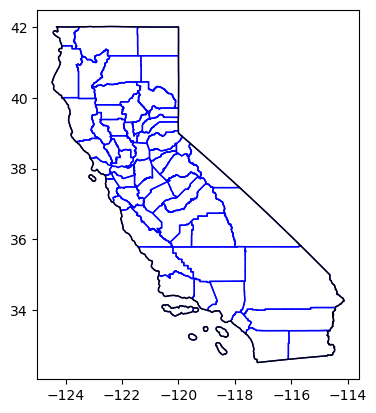

In [82]:
'''
Geometry
'''

state = gpd.read_file('Data/Geometry/california.shp')
counties = gpd.read_file('Data/Geometry/california_counties.shp')

fig, ax = plt.subplots()

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

In [154]:
import momepy

gdf = gpd.read_file(
    '/home/aaron/Downloads/California_Transmission/TransmissionLine_CEC.shp'
)

# gdf = gdf.head(1000)

gdf = gdf.to_crs(4326)

# gdf.geometry = momepy.close_gaps(gdf, .1)

gdf.kV_Sort.unique(), gdf.Circuit.unique()

(array([115. ,  34. ,  69. , 220. , 230. ,  33. , 250. , 500. ,  92. ,
        161. ,  34.5, 138. , 287. ,  60. , 110. , 345. ,  70. ,  66. ,
         55. ,   0. , 200. ]),
 array(['Single', 'Double', None, 'Many', 'Quad'], dtype=object))

In [165]:
import momepy

lmp = gpd.read_file(
    '/home/aaron/Downloads/LMP_Shapefile/LMP/caiso_lmp.shp'
)

# gdf = gdf.to_crs(4326)

In [197]:
deep_reload(nice)

x = lmp.centroid.x
y = lmp.centroid.y

d = nice.in_polygon._points_in_polygons(state.explode().geometry, x, y)

# np.unique(d)
(d.sum(axis = 0) > 0).sum()

lmp['d'] = d.sum(axis = 0) > 0

In [156]:
deep_reload(nice)
kw = {
    'node_attributes': {
  #       'name': lambda e: e['Name'],
  #       'status': lambda e: e['Status'],
		# 'voltage': lambda e: float(e.get('kV_Sort', '0')) * 1000,
    },
    'link_attributes': {
        'name': lambda e: e['Name'],
        'status': lambda e: e['Status'],
		'voltage': lambda e: float(e.get('kV_Sort', '0')) * 1000,
    },
}

gdf = gdf.explode()

lines = nice.graph.graph_from_gdf(gdf)
lines = nice.graph.reformat_graph(lines, **kw)

lines = nice.graph.remove_self_edges(lines)

# lines = nice.graph.subgraph(
#     lines, [k for k, n in lines._node.items() if n['voltage'] >= 150e3]
# )

In [157]:
lines.number_of_nodes(), lines.number_of_edges()

(11263, 6738)

In [158]:
np.unique([len(l) for l in lines._adj.values()], return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([   3, 9701, 1015,  451,   80,    8,    3,    2]))

<Axes: >

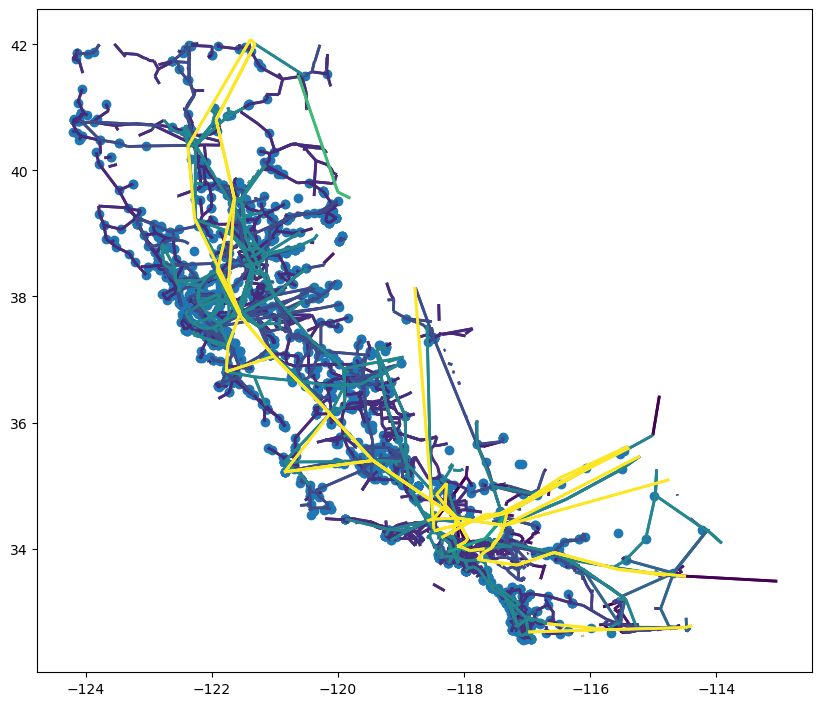

In [201]:
fig, ax = plt.subplots(figsize = (10, 10))

# counties.plot(ax = ax, fc = 'none', ec = 'b')
# state.plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'field': 'voltage',
    'plot': {
        # 'color': 'gray',
        'lw': 2,
    },
}
    
_ = nice.plot.plot_edges(lines, ax = ax, **kw)
# _ = nice.plot.plot_nodes(lines, ax = ax, **kw)


lmp[lmp['d']].plot(ax = ax)

In [203]:
'''
Data
'''

atlas = nice.graph.graph_from_json('Data/atlas.json')

stations = nice.graph.graph_from_json('Data/stations.json')

places = nice.graph.graph_from_json('Data/places_50k.json')

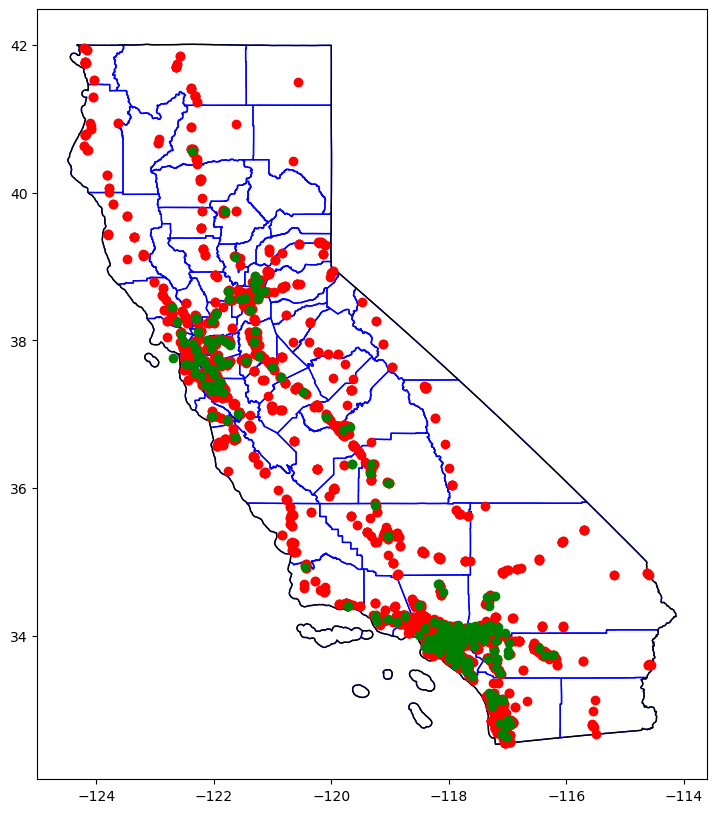

In [204]:
fig, ax = plt.subplots(figsize = (10, 10))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'plot': {
        'color': 'gray',
    },
}
    
# _ = nice.plot.plot_edges(atlas, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'green',
    },
}
    
_ = nice.plot.plot_nodes(places, ax = ax, **kw)

In [63]:
roads = gpd.read_file('/media/aaron/Extreme SSD/Atlas_Source/California_Roads.shp')
roads = roads.to_crs(4326)

In [64]:
roads.keys()

Index(['OBJECTID', 'ID', 'DIR', 'LENGTH', 'LINKID', 'COUNTRY', 'JURISCODE',
       'JURISNAME', 'ROADNUM', 'ROADNAME', 'ADMIN', 'SURFACE', 'LANES',
       'SPEEDLIM', 'CLASS', 'NHS', 'BORDER', 'ShapeSTLen', 'geometry'],
      dtype='object')

In [65]:
roads.head(5)

,OBJECTID,ID,DIR,LENGTH,LINKID,COUNTRY,JURISCODE,JURISNAME,ROADNUM,ROADNAME,ADMIN,SURFACE,LANES,SPEEDLIM,CLASS,NHS,BORDER,ShapeSTLen,geometry
0,22,440322,0,0.45,02_2876875,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,64,3,10,0,542.754634,"LINESTRING (-117.81239 33.55472, -117.8121 33...."
1,23,440617,0,0.02,02_2876938,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,64,3,10,0,18.261974,"LINESTRING (-117.80807 33.55304, -117.80802 33..."
2,24,440616,0,0.70,02_2876950,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,64,3,10,0,839.703926,"LINESTRING (-117.80791 33.55302, -117.80744 33..."
3,25,440621,0,0.15,02_2877050,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,72,3,10,0,176.664288,"LINESTRING (-117.79475 33.54641, -117.79471 33..."
4,26,440622,0,0.11,02_2877079,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,72,3,10,0,134.527078,"LINESTRING (-117.79341 33.54571, -117.79256 33..."


In [66]:
roads.CLASS.unique(), roads.NHS.unique()

(array([3, 2, 1, 5, 4, 6]), array([10,  0,  1,  7,  8,  4,  3,  9]))

<Axes: >

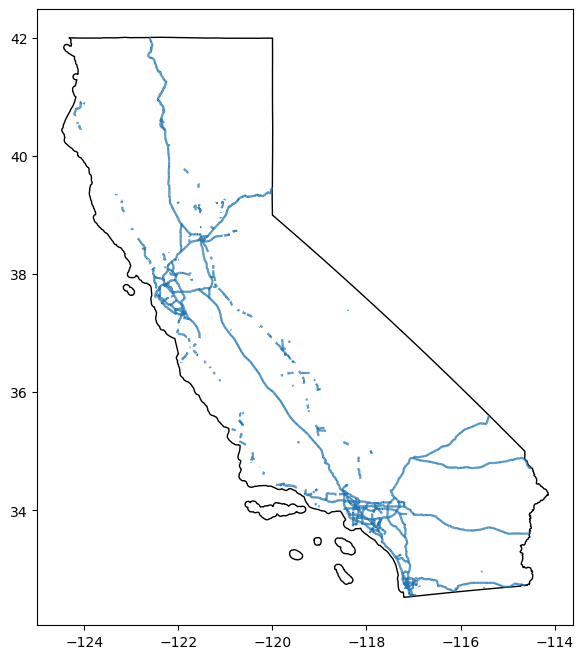

In [91]:
fig, ax = plt.subplots(figsize = (10, 8))

# counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

roads[roads['CLASS'] < 3].plot(ax = ax)

In [66]:
roads.CLASS.unique(), roads.NHS.unique()

(array([3, 2, 1, 5, 4, 6]), array([10,  0,  1,  7,  8,  4,  3,  9]))

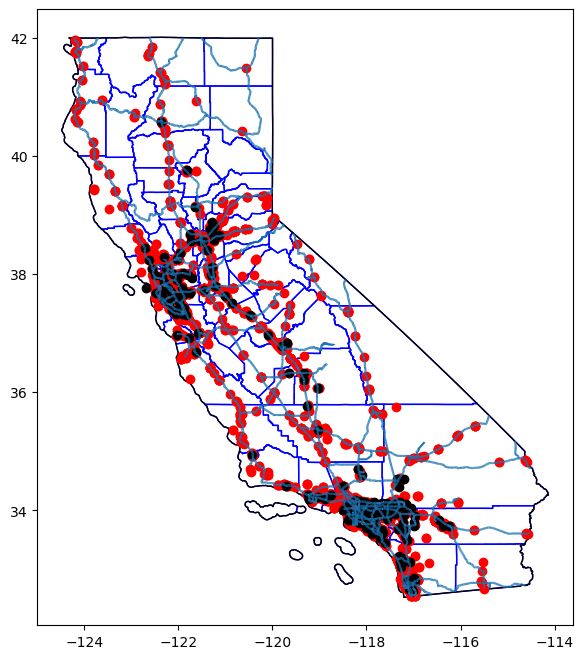

In [114]:
fig, ax = plt.subplots(figsize = (10, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

roads[roads.apply(lambda r: r['NHS'] in [1, 3, 4, 7, 8, 9], axis = 1)].plot(ax = ax)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'k',
    },
}
    
_ = nice.plot.plot_nodes(places, ax = ax, **kw)

In [115]:
stations.number_of_nodes(), places.number_of_nodes()

(3297, 178)

In [122]:
roads.head(5)

,OBJECTID,ID,DIR,LENGTH,LINKID,COUNTRY,JURISCODE,JURISNAME,ROADNUM,ROADNAME,ADMIN,SURFACE,LANES,SPEEDLIM,CLASS,NHS,BORDER,ShapeSTLen,geometry
0,22,440322,0,0.45,02_2876875,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,64,3,10,0,542.754634,"LINESTRING (-117.81239 33.55472, -117.8121 33...."
1,23,440617,0,0.02,02_2876938,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,64,3,10,0,18.261974,"LINESTRING (-117.80807 33.55304, -117.80802 33..."
2,24,440616,0,0.70,02_2876950,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,64,3,10,0,839.703926,"LINESTRING (-117.80791 33.55302, -117.80744 33..."
3,25,440621,0,0.15,02_2877050,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,72,3,10,0,176.664288,"LINESTRING (-117.79475 33.54641, -117.79471 33..."
4,26,440622,0,0.11,02_2877079,2,02_06,California,S1,PACIFIC COAST HWY,State,Paved,4,72,3,10,0,134.527078,"LINESTRING (-117.79341 33.54571, -117.79256 33..."


In [121]:
roads.keys()

Index(['OBJECTID', 'ID', 'DIR', 'LENGTH', 'LINKID', 'COUNTRY', 'JURISCODE',
       'JURISNAME', 'ROADNUM', 'ROADNAME', 'ADMIN', 'SURFACE', 'LANES',
       'SPEEDLIM', 'CLASS', 'NHS', 'BORDER', 'ShapeSTLen', 'geometry'],
      dtype='object')

In [119]:
deep_reload(nice)

major_roads = roads[roads.apply(lambda r: r['NHS'] in [1, 3, 4, 7, 8, 9], axis = 1)]
mr_graph = nice.graph.graph_from_gdf(major_roads)

In [128]:
kw = {
    'node_attributes': {
    },
    'link_attributes': {
        'distance': lambda e: e['LENGTH'] * 1e3,
		'speed': lambda e: e['SPEEDLIM'] / 3.6 ,
		'time': lambda e: (e['LENGTH'] * 1e3) / (e['SPEEDLIM'] / 3.6),
        'number': lambda e: e['ROADNUM'],
        'name': lambda e: e['ROADNAME'],
        'nhs': lambda e: e['NHS'],
        'class': lambda e: e['CLASS'],
    },
}
        
mr_graph = nice.graph.reformat_graph(mr_graph, **kw)

In [207]:
counties_s = [
    'Kern', 'San Luis Obispo', 'Kings', 'Tulare',
    'Monterey', 'Fresno', 'San Benito', 'Santa Cruz',
    'Santa Clara', 'Merced', 'Madera', 'Stanislaus',
    'Mariposa', 'San Joaquin', 'Toulumne', 'Calaveras',
    'Santa Barbara', 'Ventura', 'Los Angeles', 'San Bernardino',
    'Orange', 'San Mateo', 'Alameda', 'San Francisco',
    'Contra Costa', 'Marin', 'Sonoma', 'Napa', 'Yolo',
    'Solano', 'Sutter', 'Sacramento', 'El Dorado',
    'Placer', 'Amador',
]

counties = counties.explode()

polygons = counties.geometry.to_list()
names = counties.NAME.to_numpy()

x = [n['x'] for n in places._node.values()]
y = [n['y'] for n in places._node.values()]
s = list(places._node.keys())

place_counties = names[np.argmax(
    nice.in_polygon._points_in_polygons(polygons, x, y), axis = 0
)]

for idx in range(len(x)):

    places._node[s[idx]]['county'] = place_counties[idx]

places_s = nice.graph.subgraph(
    places, [k for k, n in places._node.items() if n['county'] in counties_s]
)

In [318]:
atlas_r = nice.graph.graph_from_json('Data/reduced_atlas.json')

In [319]:
atlas_r.number_of_nodes()

7634

In [320]:
deep_reload(nice)

graph_to_atlas, atlas_to_graph = nice.graph.node_assignment(atlas_r, places_s)

# node_assignment

nodes = []
origins = list(places_s.nodes())

for origin in nice.progress_bar.ProgressBar(origins):

    _, _, paths = nice.graph.dijkstra(
        atlas_r, [graph_to_atlas[origin]], objective = 'time',
    )

    nodes.extend(
        list(
            np.unique(np.concatenate([p for k, p in paths.items() if k in atlas_to_graph]))
        )
    )
            

    # nodes_seen = n

    # print(paths)

    # break


# predecessors, values, paths = nice.routing.all_pairs_shortest_paths(

 [---------->] (147/147) 100.00%, 24.13 it/s, 6.13 s elapsed, 0.00 s remaining

In [321]:
used = np.unique(nodes)

atlas_used = nice.graph.subgraph(
    atlas_r, used
)

In [342]:
atlas_r.number_of_nodes()

7634

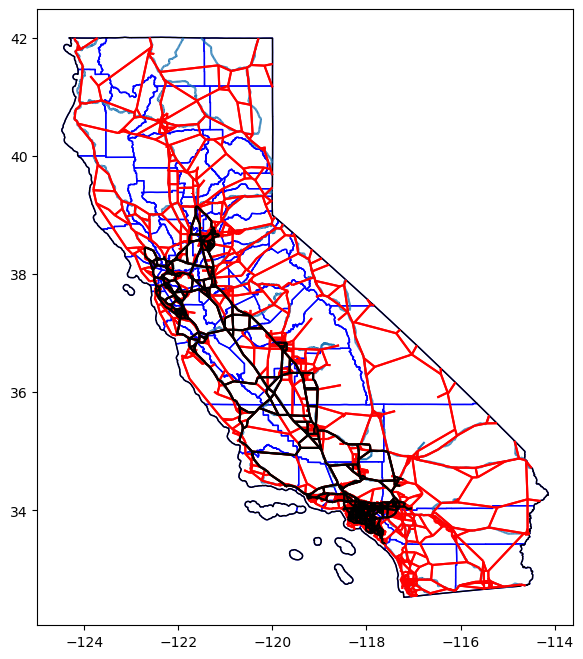

In [322]:
fig, ax = plt.subplots(figsize = (10, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

roads[roads.apply(lambda r: r['NHS'] in [1, 3, 4, 7, 8, 9], axis = 1)].plot(ax = ax)

kw = {
    'plot': {
        'color': 'red',
    },
}
    
_ = nice.plot.plot_edges(atlas_r, ax = ax, **kw)

kw = {
    'plot': {
        'color': 'k',
    },
}
    
_ = nice.plot.plot_edges(atlas_used, ax = ax, **kw)

In [323]:
deep_reload(nice)

node_assignment_a = nice.graph.relate(atlas_used, stations)
node_assignment_p = nice.graph.relate(places, stations)

keep = np.intersect1d(
    [n['id_graph'] for n in node_assignment_a if n['distance'] <= 1e3],
    [n['id_graph'] for n in node_assignment_p if n['distance'] >= 10e3]
)

print(len(keep))

284


In [324]:
stations_s = nice.graph.subgraph(
    stations, keep
)

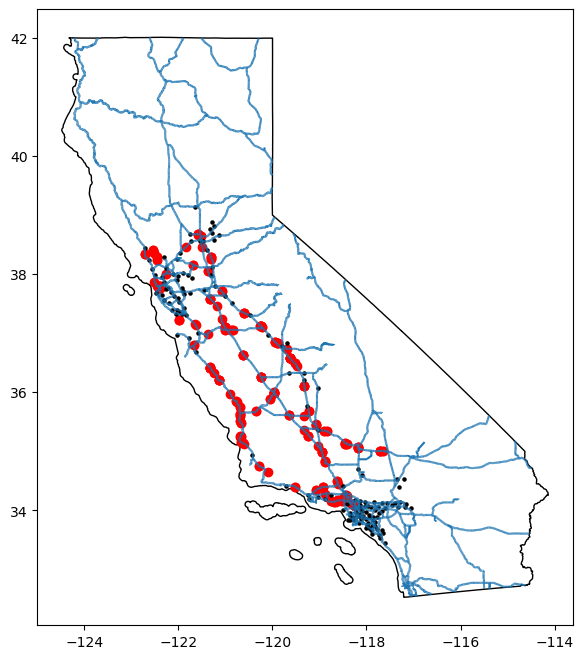

In [325]:
fig, ax = plt.subplots(figsize = (8, 8))

# counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

roads[roads.apply(lambda r: r['NHS'] in [1, 3, 4, 7, 8, 9], axis = 1)].plot(ax = ax)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations_s, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'k',
        's': 5,
    },
}
    
_ = nice.plot.plot_nodes(places_s, ax = ax, **kw)

In [345]:
new_graph = nice.graph.supergraph([places_s])

In [346]:
new_graph = nice.graph.adjacency(atlas_r, new_graph, objective = 'time')

 [---------->] (147/147) 100.00%, 22.42 it/s, 6.60 s elapsed, 0.00 s remaining

In [347]:
new_graph.number_of_nodes(), new_graph.number_of_edges()

(147, 10878)

In [348]:
n = 0

for source, _adj in new_graph._adj.items():
    for target, edge in _adj.items():

        n += (edge['distance'] > 150e3) and (edge['distance'] < 300e3)

n

2408

In [358]:
deep_reload(nice)

destinations = [n for n in new_graph.nodes() if 'CA' in n][:3]

lg = nice.optimization.level_graph(
    new_graph, 'Fresno, CA', objective = 'distance', destinations = destinations
)

lg.number_of_nodes(), lg.number_of_edges()

(147, 9820)

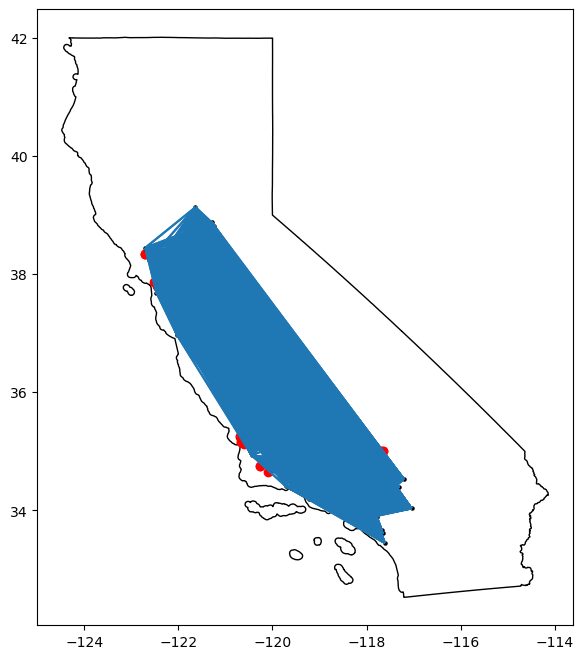

In [359]:
fig, ax = plt.subplots(figsize = (8, 8))

# counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

# roads[roads.apply(lambda r: r['NHS'] in [1, 3, 4, 7, 8, 9], axis = 1)].plot(ax = ax)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations_s, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'k',
        's': 5,
    },
}
    
_ = nice.plot.plot_nodes(places_s, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'k',
        's': 5,
    },
}
    
_ = nice.plot.plot_edges(lg, ax = ax)

In [341]:
431 ** 2

185761

In [277]:
len([n for n in node_assignment if n['distance'] <= 1e3])

(3297, 2019)

In [148]:
stations_hwy = nice.graph.subgraph(
    stations, [n['id_graph'] for n in node_assignment if n['distance'] <= 1e3]
)

In [149]:
stations_hwy_t = nice.graph.subgraph(
    stations_hwy, [k for k, n in stations_hwy._node.items() if n['network'] == 'Tesla']
)

In [150]:
stations_hwy.number_of_nodes(), stations_hwy_t.number_of_nodes()

(2150, 341)

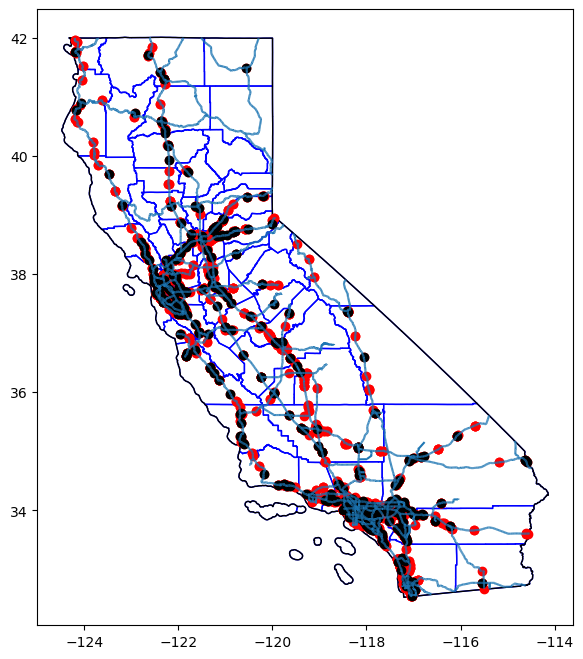

In [151]:
fig, ax = plt.subplots(figsize = (10, 8))

counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

roads[roads.apply(lambda r: r['NHS'] in [1, 3, 4, 7, 8, 9], axis = 1)].plot(ax = ax)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations_hwy, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'k',
    },
}
    
_ = nice.plot.plot_nodes(stations_hwy_t, ax = ax, **kw)

In [182]:
deep_reload(nice)

counties = counties.explode()

polygons = counties.geometry.to_list()
names = counties.NAME.to_numpy()

x = [n['x'] for n in stations._node.values()]
y = [n['y'] for n in stations._node.values()]
s = list(stations._node.keys())

station_counties = names[nice.in_polygon._points_in_polygons(polygons, x, y)]
station_counties

for idx in range(len(x)):

    # print(station_counties[idx])

    stations._node[s[idx]]['county'] = station_counties[idx]

# for source, node in stations._node.items():

#     node['county'] = names[nice.in_polygon._points_in_polygons(
#         polygons, [node['x']], [node['y']],
#     )]

In [204]:
counties_s = [
    'Kern', 'San Luis Obispo', 'Kings', 'Tulare',
    'Monterey', 'Fresno', 'San Benito', 'Santa Cruz',
    'Santa Clara', 'Merced', 'Madera', 'Stanislaus',
    'Mariposa', 'San Joaquin', 'Toulumne', 'Calaveras',
    'Santa Barbara', 'Ventura', 'Los Angeles', 'San Bernardino',
    'Orange', 'San Mateo', 'Alameda', 'San Francisco',
    'Contra Costa', 'Marin', 'Sonoma', 'Napa', 'Yolo',
    'Solano', 'Sutter', 'Sacramento', 'El Dorado',
    'Placer', 'Amador',
]

counties = counties.explode()

polygons = counties.geometry.to_list()
names = counties.NAME.to_numpy()

x = [n['x'] for n in places._node.values()]
y = [n['y'] for n in places._node.values()]
s = list(places._node.keys())

place_counties = names[nice.in_polygon._points_in_polygons(polygons, x, y)]

for idx in range(len(x)):

    places._node[s[idx]]['county'] = place_counties[idx]

places_s = nice.graph.subgraph(
    places, [k for k, n in places._node.items() if n['county'] in counties_s]
)

In [226]:
counties_s = [
    'Kern', 'San Luis Obispo', 'Kings', 'Tulare',
    'Monterey', 'Fresno', 'San Benito', 'Santa Cruz',
    'Santa Clara', 'Merced', 'Madera', 'Stanislaus',
    'Mariposa', 'San Joaquin', 'Toulumne', 'Calaveras',
    'Santa Barbara', 'Ventura',
]

counties_s = [
    'Kern', 'San Luis Obispo', 'Kings', 'Tulare',
    'Monterey', 'Fresno', 'San Benito', 'Santa Cruz',
    'Santa Clara', 'Merced', 'Madera', 'Stanislaus',
    'Mariposa', 'San Joaquin', 'Toulumne', 'Calaveras',
    'Santa Barbara', 'Ventura', 'Los Angeles',
    'San Mateo', 'Alameda', 'San Francisco',
    'Contra Costa', 'Solano',
    'Sacramento', 'San Bernardino',
]

counties = counties.explode()

polygons = counties.geometry.to_list()
names = counties.NAME.to_numpy()

x = [n['x'] for n in stations._node.values()]
y = [n['y'] for n in stations._node.values()]
s = list(stations._node.keys())

station_counties = names[nice.in_polygon._points_in_polygons(polygons, x, y)]

for idx in range(len(x)):

    stations._node[s[idx]]['county'] = station_counties[idx]

node_assignment = nice.graph.relate(mr_graph, stations)

stations_hwy = nice.graph.subgraph(
    stations, [n['id_graph'] for n in node_assignment if n['distance'] <= 1e3]
)

stations_hwy_s = nice.graph.subgraph(
    stations_hwy, [k for k, n in stations_hwy._node.items() if n['county'] in counties_s]
)

node_assignment = nice.graph.relate(places, stations_hwy_s)

stations_s = nice.graph.subgraph(
    stations_hwy_s, [n['id_graph'] for n in node_assignment if n['distance'] >= 5e3]
)

stations_s.number_of_nodes()

739

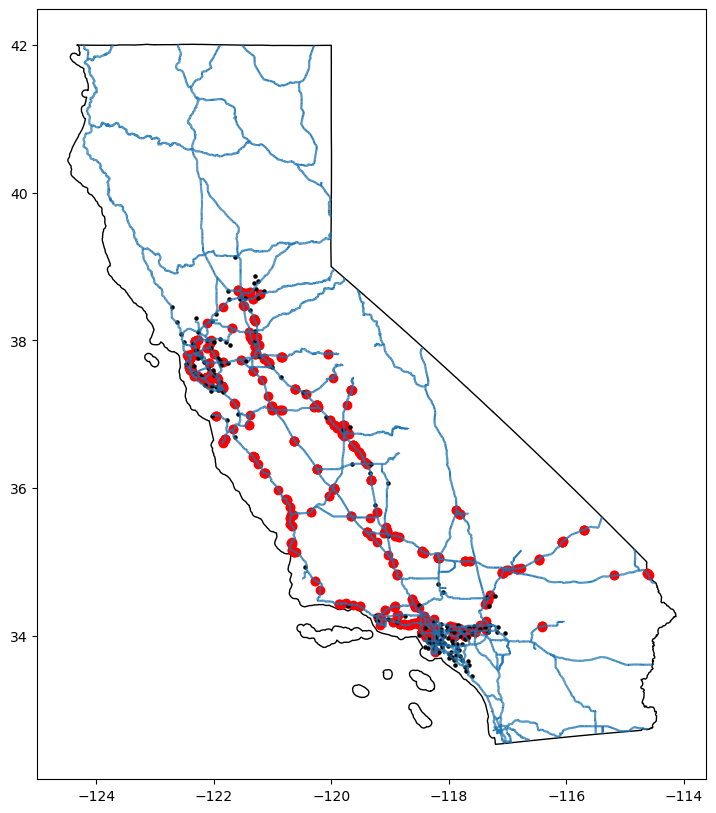

In [227]:
fig, ax = plt.subplots(figsize = (10, 10))

# counties.plot(ax = ax, fc = 'none', ec = 'b')
state.plot(ax = ax, fc = 'none', ec = 'k')

roads[roads.apply(lambda r: r['NHS'] in [1, 3, 4, 7, 8, 9], axis = 1)].plot(ax = ax)

kw = {
    'plot': {
        'fc': 'red',
    },
}
    
_ = nice.plot.plot_nodes(stations_s, ax = ax, **kw)

kw = {
    'plot': {
        'fc': 'k',
        's': 5,
    },
}
    
_ = nice.plot.plot_nodes(places_s, ax = ax, **kw)